In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [0]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout, UpSampling1D, BatchNormalization
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Plot statistical data such as Annotated heatmaps
import math

import time, datetime

Using TensorFlow backend.


In [0]:
INPUT_SIZE = 200

TENSORBOARD_LOGS_PATH = '/content/drive/colab/logs'

# MAIN_FOLDER = ('/content/drive/colab/LSTM/{}/').format(datetime.datetime.now().isoformat())
# MAIN_FOLDER = ('/content/drive/colab/CNN/{}/').format(datetime.datetime.now().isoformat())
MAIN_FOLDER = ('/content/drive/colab/AUTOENCODER/{}/').format(datetime.datetime.now().isoformat())

ENCODER_MODEL_PATH = '/content/drive/colab/models/encoder_model2.h5'
CHECK_POINT_PATH = 'weights.best.hdf5'

# DATASET_PATH = "/content/drive/colab/Datasets/dataset1.csv"
# DATASET_PATH = "/content/drive/colab/Datasets/dataset2.csv"
DATASET_PATH = "/content/drive/colab/Datasets/dataset3.csv"

optimizer = 'adam'
loss = 'binary_crossentropy'
activation = 'relu'
batch_size = 64
epochs = 200
dropout = 0.2

os.mkdir(MAIN_FOLDER)
print(MAIN_FOLDER)

main_information = list()

/content/drive/colab/AUTOENCODER/2019-04-16T21:27:23.289363/


# Create Tokenizer and vocabulary

In [0]:
# Create tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')

In [0]:
def get_alphabet():
    ''' Create alphabet from ASCII character '''
    char_dict = {}
    for num in range(127):
        char_dict[chr(num)] = num + 1
    return char_dict

In [0]:
# Create Alphabet Vocabulary (Dictonary)
char_dict = get_alphabet()
print(char_dict)

{'\x00': 1, '\x01': 2, '\x02': 3, '\x03': 4, '\x04': 5, '\x05': 6, '\x06': 7, '\x07': 8, '\x08': 9, '\t': 10, '\n': 11, '\x0b': 12, '\x0c': 13, '\r': 14, '\x0e': 15, '\x0f': 16, '\x10': 17, '\x11': 18, '\x12': 19, '\x13': 20, '\x14': 21, '\x15': 22, '\x16': 23, '\x17': 24, '\x18': 25, '\x19': 26, '\x1a': 27, '\x1b': 28, '\x1c': 29, '\x1d': 30, '\x1e': 31, '\x1f': 32, ' ': 33, '!': 34, '"': 35, '#': 36, '$': 37, '%': 38, '&': 39, "'": 40, '(': 41, ')': 42, '*': 43, '+': 44, ',': 45, '-': 46, '.': 47, '/': 48, '0': 49, '1': 50, '2': 51, '3': 52, '4': 53, '5': 54, '6': 55, '7': 56, '8': 57, '9': 58, ':': 59, ';': 60, '<': 61, '=': 62, '>': 63, '?': 64, '@': 65, 'A': 66, 'B': 67, 'C': 68, 'D': 69, 'E': 70, 'F': 71, 'G': 72, 'H': 73, 'I': 74, 'J': 75, 'K': 76, 'L': 77, 'M': 78, 'N': 79, 'O': 80, 'P': 81, 'Q': 82, 'R': 83, 'S': 84, 'T': 85, 'U': 86, 'V': 87, 'W': 88, 'X': 89, 'Y': 90, 'Z': 91, '[': 92, '\\': 93, ']': 94, '^': 95, '_': 96, '`': 97, 'a': 98, 'b': 99, 'c': 100, 'd': 101, 'e': 1

In [0]:
# Create vocabulary and Add it into the tokenizer
tk.word_index = char_dict.copy()
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
print(tk.word_index)

{'\x00': 1, '\x01': 2, '\x02': 3, '\x03': 4, '\x04': 5, '\x05': 6, '\x06': 7, '\x07': 8, '\x08': 9, '\t': 10, '\n': 11, '\x0b': 12, '\x0c': 13, '\r': 14, '\x0e': 15, '\x0f': 16, '\x10': 17, '\x11': 18, '\x12': 19, '\x13': 20, '\x14': 21, '\x15': 22, '\x16': 23, '\x17': 24, '\x18': 25, '\x19': 26, '\x1a': 27, '\x1b': 28, '\x1c': 29, '\x1d': 30, '\x1e': 31, '\x1f': 32, ' ': 33, '!': 34, '"': 35, '#': 36, '$': 37, '%': 38, '&': 39, "'": 40, '(': 41, ')': 42, '*': 43, '+': 44, ',': 45, '-': 46, '.': 47, '/': 48, '0': 49, '1': 50, '2': 51, '3': 52, '4': 53, '5': 54, '6': 55, '7': 56, '8': 57, '9': 58, ':': 59, ';': 60, '<': 61, '=': 62, '>': 63, '?': 64, '@': 65, 'A': 66, 'B': 67, 'C': 68, 'D': 69, 'E': 70, 'F': 71, 'G': 72, 'H': 73, 'I': 74, 'J': 75, 'K': 76, 'L': 77, 'M': 78, 'N': 79, 'O': 80, 'P': 81, 'Q': 82, 'R': 83, 'S': 84, 'T': 85, 'U': 86, 'V': 87, 'W': 88, 'X': 89, 'Y': 90, 'Z': 91, '[': 92, '\\': 93, ']': 94, '^': 95, '_': 96, '`': 97, 'a': 98, 'b': 99, 'c': 100, 'd': 101, 'e': 1

In [0]:
vocab_size = len(tk.word_index)
print(vocab_size)

128


# Loading Dataset

In [0]:
dataset_df = pd.read_csv(DATASET_PATH, header=None)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10126 entries, 0 to 10125
Data columns (total 3 columns):
0    10126 non-null int64
1    10126 non-null object
2    10126 non-null object
dtypes: int64(1), object(2)
memory usage: 237.4+ KB


In [0]:
dataset_df.head()

,0,1,2
0,1,PelopsException pelopsException = translator....,PelopsException pelopsException = translator....
1,1,ArrayList<Context> javaList = new ArrayList<C...,ArrayLXXXXXst<Context> javaLXXXXXst = new Arr...
2,1,ResilientPropagation rprop = new ResilientPro...,ResilientPropagation XXXXX = new ResilientPro...
3,0,new DateTimeService().setCurrentDateTime(star...,if ((mask & 1) != 0) count1++; if ((mask & 2)...
4,0,Thread thread = Thread.currentThread(); Threa...,Parameters p = object.getClass().getAnnotatio...


In [0]:
dataset_df = dataset_df.drop([0], axis=1)
dataset_df = dataset_df.drop([2], axis=1)

In [0]:
dataset_df.info()
dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10126 entries, 0 to 10125
Data columns (total 1 columns):
1    10126 non-null object
dtypes: object(1)
memory usage: 79.2+ KB


,1
0,PelopsException pelopsException = translator....
1,ArrayList<Context> javaList = new ArrayList<C...
2,ResilientPropagation rprop = new ResilientPro...
3,new DateTimeService().setCurrentDateTime(star...
4,Thread thread = Thread.currentThread(); Threa...


In [0]:
# Divide dataset into training and testing
train_data, test_data = train_test_split(dataset_df[1].values, test_size=0.2)
train_data, validation_data = train_test_split(train_data, test_size=0.2)
print(len(train_data))
print(len(test_data))
print(len(validation_data))

6480
2026
1620


# Create Embedding weights

In [0]:
# One hot array representation
embedding_weights = []
embedding_weights.append(np.zeros(vocab_size))
for char, i in tk.word_index.items():
    onehot = np.zeros(vocab_size)
    onehot[i-1] = 1
    embedding_weights.append(onehot)

embedding_weights = np.array(embedding_weights)
print(embedding_weights.shape)
print(embedding_weights)

(129, 128)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


# Create Model

## Defined Parameters

In [0]:
input_size = INPUT_SIZE       # Must be same as an argument max_len inside pad_sequence method
embedding_size = vocab_size   # vocab size 128
optimizer = 'adam'
loss = 'mse'
dropout = 0.2
batch_size = 64
epochs = 500


## Input and Embedding Layers

In [0]:
# input layer (shape=(None, 200))
inputs = Input(shape=(input_size,), name='input_layer', dtype='int32')

In [0]:
# embedding layer (input_dim=129, output_dim=128, input_length=200, weights=(129, 128))
embedding_layer = Embedding(vocab_size + 1, embedding_size, input_length=input_size, weights=[embedding_weights])

In [0]:
x = embedding_layer(inputs)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
embedding_layer.name

'embedding_1'

## Encoder layers

In [0]:
x = Conv1D(128, 5, activation='relu', padding="same")(x)
x = MaxPooling1D(pool_size=5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=4, padding="same")(x)
x = BatchNormalization()(x)
x = Conv1D(128, 5, activation='relu', padding='same', name='conv_encoder')(x)
x = BatchNormalization()(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Decoder layers

In [0]:
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling1D(4)(x)
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling1D(5)(x)
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)

In [0]:
# Fully connected layer
x = Flatten()(x)
x = Dense(200, activation='relu')(x)
predictions = x

## Build Model

In [0]:
# Build and compile model
autoencoder = Model(inputs=inputs, outputs=predictions)
# opt = adam, loss = mse
autoencoder.compile(loss=loss, optimizer = optimizer,
              metrics=['accuracy'])

In [0]:
# Print summary of the model
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          16512     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 128)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
conv_encoder (Conv1D)        (None, 40, 128)           82048     
__________

## Setup Callbacks

In [0]:
tensorboard = TensorBoard(log_dir=TENSORBOARD_LOGS_PATH, 
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)

In [0]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.01, 
                           patience=5, # Num of epochs with no improvement after which training stops
                           verbose=1)

In [0]:
checkpoint = ModelCheckpoint(MAIN_FOLDER + CHECK_POINT_PATH, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

## Train model

In [0]:
# Convert string to index 
train_sequences = tk.texts_to_sequences(train_data)
test_sequences = tk.texts_to_sequences(test_data)
validation_sequences = tk.texts_to_sequences(validation_data)

# Padding
train = pad_sequences(train_sequences, maxlen=200, padding='post')
test = pad_sequences(test_sequences, maxlen=200, padding='post')
validation = pad_sequences(validation_sequences, maxlen=200, padding='post')

# Convert to numpy array
train = np.array(train, dtype='float32')
test = np.array(test, dtype='float32')
validation = np.array(validation, dtype='float32')

In [0]:
print(len(train))
print(len(test_data))
print(len(validation_data))

x_val = validation
y_val = validation

x_train = train
y_train = train

6480
2026
1620


In [0]:
autoencoder_train = autoencoder.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint])


Instructions for updating:
Use tf.cast instead.
Train on 6480 samples, validate on 1620 samples
Epoch 1/500
6480/6480 [==============================] - 5s 725us/step - loss: 1282.4423 - acc: 0.0025 - val_loss: 665.6196 - val_acc: 0.0037

Epoch 00001: val_acc improved from -inf to 0.00370, saving model to /content/drive/colab/AUTOENCODER/2019-04-16T21:27:23.289363/weights.best.hdf5
Epoch 2/500
6480/6480 [==============================] - 2s 260us/step - loss: 510.5454 - acc: 0.0019 - val_loss: 446.5192 - val_acc: 0.0012

Epoch 00002: val_acc did not improve from 0.00370
Epoch 3/500
6480/6480 [==============================] - 2s 246us/step - loss: 392.8922 - acc: 0.0042 - val_loss: 363.4610 - val_acc: 0.0025

Epoch 00003: val_acc did not improve from 0.00370
Epoch 4/500
6480/6480 [==============================] - 2s 246us/step - loss: 340.0446 - acc: 0.0042 - val_loss: 322.0000 - val_acc: 0.0043

Epoch 00004: val_acc improved from 0.00370 to 0.00432, saving model to /content/drive/col

# Display Output of embedding layer

In [0]:
layer_name = 'embedding_1'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test)

In [0]:
print(intermediate_output[0][2])
print(test[0][2])
print(test_data[0][2])
print(tk.word_index[test_data[0][2]])

[-1.44445866e-01 -8.63007382e-02 -1.29414245e-01 -1.08260408e-01
  5.58174215e-02  1.29623160e-01 -4.06452790e-02  1.23723909e-01
 -1.17009908e-01  1.29321665e-01  4.66580726e-02  3.17389041e-01
  1.21774450e-01 -1.37701720e-01  1.84139013e-01 -1.23050034e-01
 -1.02554090e-01  4.68946956e-02  8.55813175e-02 -6.77267462e-02
 -6.03331625e-02 -1.90901384e-01 -3.98145169e-01 -1.91551879e-01
  1.15138419e-01  2.77352691e-01 -1.08017869e-01 -5.93758598e-02
  6.41453862e-02 -8.82828608e-02 -1.36498615e-01 -2.22374082e-01
 -1.74276814e-01  5.13376445e-02  6.11800775e-02 -1.53807878e-01
 -1.25798374e-01 -1.83768949e-04  5.63302152e-02  8.88621882e-02
  4.84831305e-03  6.34139627e-02  1.25357509e-02  1.52351102e-02
  8.62910226e-02 -2.11389102e-02 -1.20583996e-02 -1.26776826e-02
  6.07163869e-02  1.52003421e-02  2.51873899e-02  4.59247194e-02
  6.88442662e-02 -2.98830047e-02  5.68836033e-02  3.40720564e-02
 -6.24874830e-02 -2.90034860e-02  9.25903618e-02 -3.42658684e-02
  6.64143413e-02 -9.58317

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


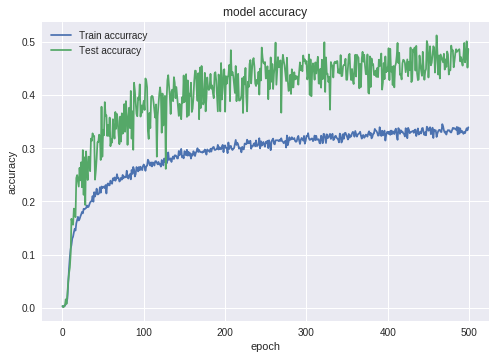

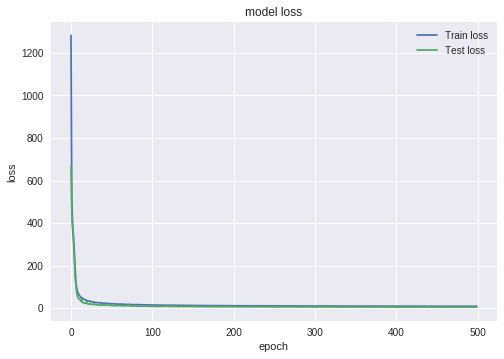

In [0]:
# autoencoder_train.history['epochs']
print(autoencoder_train.history.keys())

# summarize history for accuracy
plt.plot(autoencoder_train.history['acc'])
plt.plot(autoencoder_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accurracy', 'Test accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.show()

In [0]:
autoencoder.save('/content/drive/colab/models/autoencoder.h5')

# Extract Encoder

In [0]:
# Get Encoder
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv_encoder').output)
encoder_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          16512     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 128)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
conv_encoder (Conv1D)        (None, 40, 128)           82048     
Total para

In [0]:
# Save encoder model to the file
encoder_model.save('/content/drive/colab/models/encoder_model3.h5')
# Because compilation resets the models' weights, save them along with the model and load them after compilation
encoder_model.save_weights('/content/drive/colab/models/encoder_model_copy-weights3.h5')


In [0]:
# # Load encoder model from the file
# new_encoder_model = load_model('/content/gdrive/My Drive/colab/models/encoder_model.h5')

# new_encoder_model.compile(
#    optimizer=optimizer, 
#    loss=loss, 
#    metrics=['accuracy']
# )

# new_encoder_model.load_weights('/content/gdrive/My Drive/colab/models/encoder_model_copy-weights.h5')
